Importamos librerias necesarias para constrir los dataframes

In [8]:
import pandas as pd
from ydata_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt 
import re
import sketch
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import geojson
import folium
from folium.plugins import HeatMap
from summarytools import dfSummary
hechos=pd.read_excel('homicidios.xlsx',sheet_name='HECHOS')
victimas=pd.read_excel('homicidios.xlsx',sheet_name='VICTIMAS')
hechos.head()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
0,2016-0001,1,2016-01-01,2016,1,1,04:00:00,4,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,...,NaN,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,Point (98896.78238426 93532.43437792),-58.47533969,-34.68757022,MOTO-AUTO,MOTO,AUTO
1,2016-0002,1,2016-01-02,2016,1,2,01:15:00,1,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,...,NaN,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,Point (95832.05571093 95505.41641999),-58.50877521,-34.66977709,AUTO-PASAJEROS,AUTO,PASAJEROS
2,2016-0003,1,2016-01-03,2016,1,3,07:00:00,7,AV ENTRE RIOS 2034,AVENIDA,...,2034.0,NaN,ENTRE RIOS AV. 2034,1,Point (106684.29090040 99706.57687843),-58.39040293,-34.63189362,MOTO-AUTO,MOTO,AUTO
3,2016-0004,1,2016-01-10,2016,1,10,00:00:00,0,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,...,NaN,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,Point (99840.65224780 94269.16534422),-58.46503904,-34.68092974,MOTO-SD,MOTO,SD
4,2016-0005,1,2016-01-21,2016,1,21,05:20:00,5,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,...,NaN,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,Point (106980.32827929 100752.16915795),-58.38718297,-34.62246630,MOTO-PASAJEROS,MOTO,PASAJEROS


In [9]:
victimas.head()

,ID_hecho,FECHA,AAAA,MM,DD,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO
0,2016-0001,2016-01-01,2016,1,1,CONDUCTOR,MOTO,MASCULINO,19,2016-01-01 00:00:00
1,2016-0002,2016-01-02,2016,1,2,CONDUCTOR,AUTO,MASCULINO,70,2016-01-02 00:00:00
2,2016-0003,2016-01-03,2016,1,3,CONDUCTOR,MOTO,MASCULINO,30,2016-01-03 00:00:00
3,2016-0004,2016-01-10,2016,1,10,CONDUCTOR,MOTO,MASCULINO,18,SD
4,2016-0005,2016-01-21,2016,1,21,CONDUCTOR,MOTO,MASCULINO,29,2016-02-01 00:00:00


Realizo un merge apartir de los datos de los ID que es el campo que tienen en común

In [10]:
victimas=victimas.rename(columns={'ID_hecho':'ID'})
hechos_victimas  = hechos.merge(victimas, on='ID', how='inner')
hechos_victimas.columns

Index(['ID', 'N_VICTIMAS', 'FECHA_x', 'AAAA_x', 'MM_x', 'DD_x', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'VICTIMA_x', 'ACUSADO', 'FECHA_y', 'AAAA_y', 'MM_y',
       'DD_y', 'ROL', 'VICTIMA_y', 'SEXO', 'EDAD', 'FECHA_FALLECIMIENTO'],
      dtype='object')

Verfico que columnas de la nueva tabla construida apartir del merge no tengan informacion duplicada 

In [11]:
def comparar_columnas(df):

    columnas_diferentes = []
    columnas_iguales = []

    for columna1 in df.columns:
        for columna2 in df.columns:
            if columna1 != columna2:
                if (df[columna1] == df[columna2]).all():
                    columnas_iguales.append((columna1, columna2))
                elif not (df[columna1] == df[columna2]).all():
                    columnas_diferentes.append((columna1, columna2))

    return columnas_iguales, columnas_diferentes


columnas_iguales, columnas_diferentes = comparar_columnas(hechos_victimas[hechos_victimas.columns])

print("Contienen el mismo valor:")
for columna1, columna2 in columnas_iguales:
    print(f"{columna1} y {columna2} tienen el mismo valor")


Contienen el mismo valor:
AAAA_x y AAAA_y tienen el mismo valor
MM_x y MM_y tienen el mismo valor
AAAA_y y AAAA_x tienen el mismo valor
MM_y y MM_x tienen el mismo valor


Elimino las 2 columnas con el valor repetido

In [12]:
hechos_victimas = hechos_victimas.drop(['AAAA_y','MM_y'],axis=1)

Para las columnas que hacen referencia a valores con nombres similares, que presentan diferencias mediante una funcion que me devuelve los indices con diferencias

In [13]:
indices=[]
for index, row  in hechos_victimas[['FECHA_x','FECHA_y', 'DD_x','DD_y', 'VICTIMA_x',  'VICTIMA_y']].iterrows():

    if row['FECHA_x'] !=row['FECHA_y']:
        indices.append(index)


    if row['DD_x'] !=row['DD_y']:
        indices.append(index)
    if row['VICTIMA_x'] !=row['VICTIMA_y']:
        indices.append(index)

Mostramos solo los registros y las columnas que presentan nombres similares y valores distintos 

In [14]:
hechos_victimas[['FECHA_x','FECHA_y', 'DD_x','DD_y', 'VICTIMA_x','ACUSADO',  'VICTIMA_y','FECHA_FALLECIMIENTO' ]].iloc[indices]

,FECHA_x,FECHA_y,DD_x,DD_y,VICTIMA_x,ACUSADO,VICTIMA_y,FECHA_FALLECIMIENTO
65,2016-07-02,2016-07-03,3,3,MOTO,OBJETO FIJO,MOTO,2016-07-03 00:00:00
204,2017-05-24,2017-05-29,24,29,MOTO,SD,MOTO,2017-05-29 00:00:00
204,2017-05-24,2017-05-29,24,29,MOTO,SD,MOTO,2017-05-29 00:00:00
237,2017-09-02,2017-09-02,2,2,OBJETO FIJO,AUTO,AUTO,2017-09-02 00:00:00
238,2017-09-02,2017-09-02,2,2,OBJETO FIJO,AUTO,AUTO,2017-09-02 00:00:00
602,2020-12-05,2020-12-05,5,5,PEATON_MOTO,MOTO,PEATON,2020-12-05 00:00:00
603,2020-12-05,2020-12-05,5,5,PEATON_MOTO,MOTO,MOTO,2020-12-05 00:00:00


El campo [FECHA_Y]  corresponde a la fecha de muerte, no a la fecha del siniestro, misma situación para el dia ya que [DD_X] representa  el dia del accidente y [DD_y] representa la fecha del deceso, por lo que decido que no me sera util y lo elimino

In [15]:
hechos_victimas = hechos_victimas.drop(['FECHA_y','DD_y'],axis=1)

Filtramos en este caso por la columna [VICTIMA_X] la cual indica que es un 'OBJETO FIJO', constrastandolo con el campo [VICTIMA_Y] el cual especifica que es un AUTO.

In [16]:
tipo_victima = hechos_victimas.loc[hechos_victimas['VICTIMA_x'] == 'OBJETO FIJO'][['ID','FECHA_x','DD_x','ACUSADO','VICTIMA_x', 'VICTIMA_y','FECHA_FALLECIMIENTO']]
tipo_victima

,ID,FECHA_x,DD_x,ACUSADO,VICTIMA_x,VICTIMA_y,FECHA_FALLECIMIENTO
237,2017-0108,2017-09-02,2,AUTO,OBJETO FIJO,AUTO,2017-09-02 00:00:00
238,2017-0108,2017-09-02,2,AUTO,OBJETO FIJO,AUTO,2017-09-02 00:00:00


Se intercambian valores entre acusado y VICTIMA_x

In [17]:
def columns_modifier(mode,DF,columns, value, replace=None):
    df=DF.copy()
    if mode == 'swap':
        for index, row in df.iterrows():

            value_1=row[columns[0]]
            value_2=row[columns[1]]

            if value_1== value:
                temp=value_1
                df.at[index, columns[0]] = value_2
                df.at[index, columns[1]] = temp
    if mode == 'replace':
        for index, row in df.iterrows():
            to_replace=row[columns[0]]

            if to_replace == value:
                df.at[index, columns[0]] = replace
    
    return df
columns=['VICTIMA_x','ACUSADO']
hechos_victimas=columns_modifier('swap',hechos_victimas,columns,'OBJETO FIJO')
hechos_victimas[['FECHA_x', 'DD_x', 'VICTIMA_x','ACUSADO',  'VICTIMA_y','FECHA_FALLECIMIENTO' ]].iloc[indices]

,FECHA_x,DD_x,VICTIMA_x,ACUSADO,VICTIMA_y,FECHA_FALLECIMIENTO
65,2016-07-02,3,MOTO,OBJETO FIJO,MOTO,2016-07-03 00:00:00
204,2017-05-24,24,MOTO,SD,MOTO,2017-05-29 00:00:00
204,2017-05-24,24,MOTO,SD,MOTO,2017-05-29 00:00:00
237,2017-09-02,2,AUTO,OBJETO FIJO,AUTO,2017-09-02 00:00:00
238,2017-09-02,2,AUTO,OBJETO FIJO,AUTO,2017-09-02 00:00:00
602,2020-12-05,5,PEATON_MOTO,MOTO,PEATON,2020-12-05 00:00:00
603,2020-12-05,5,PEATON_MOTO,MOTO,MOTO,2020-12-05 00:00:00


Realizo un filtrado de las filas en donde las dos columnas de victima tienen valores diferentes

In [18]:
indices=[]
for index, row  in hechos_victimas[['VICTIMA_x', 'VICTIMA_y']].iterrows():
    if row['VICTIMA_x'] !=row['VICTIMA_y']:
        indices.append(index)
indices
hechos_victimas[[ 'VICTIMA_x',  'VICTIMA_y']].iloc[indices]

,VICTIMA_x,VICTIMA_y
602,PEATON_MOTO,PEATON
603,PEATON_MOTO,MOTO


Elimino la columna [VICTIMA_x] par conservar el campo [VICTIMA_y]

In [19]:
hechos_victimas = hechos_victimas.drop(['VICTIMA_x'],axis=1)
hechos_victimas.columns

Index(['ID', 'N_VICTIMAS', 'FECHA_x', 'AAAA_x', 'MM_x', 'DD_x', 'HORA', 'HH',
       'LUGAR_DEL_HECHO', 'TIPO_DE_CALLE', 'Calle', 'Altura', 'Cruce',
       'Dirección Normalizada', 'COMUNA', 'XY (CABA)', 'pos x', 'pos y',
       'PARTICIPANTES', 'ACUSADO', 'ROL', 'VICTIMA_y', 'SEXO', 'EDAD',
       'FECHA_FALLECIMIENTO'],
      dtype='object')

Renombro las colummnas

In [20]:
hechos_victimas = hechos_victimas.rename(columns={'XY (CABA)':'Puntero','FECHA_x':'FECHA', 'AAAA_x':'AAAA', 'MM_x':'MM', 'DD_x':'DD', 'pos x':'Longitud','pos y':'Latitud', 'VICTIMA_y':'VICTIMA'})

Busqueda de valores atípicos

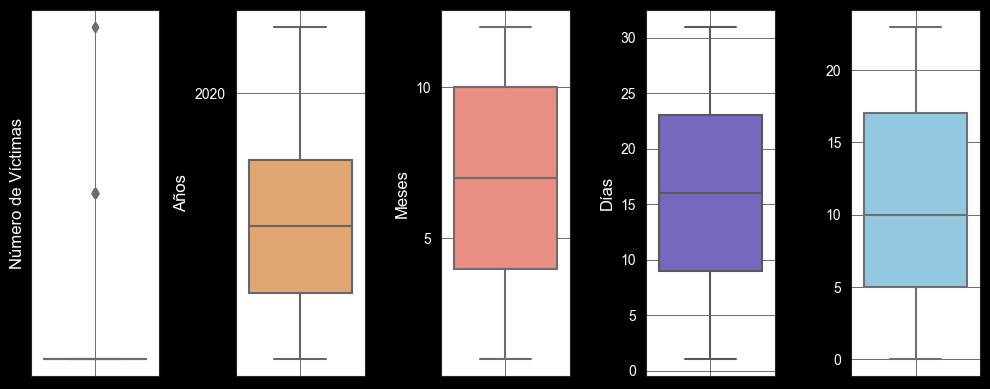

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Ajustar tamaño de la figura y fondo negro
plt.figure(figsize=(10, 4), facecolor='black')

# Cambiar estilo de gráfico
sns.set_style('white')

# Crear subplots y personalizar
plt.subplot(1, 5, 1)
sns.boxplot(data=hechos_victimas, y='N_VICTIMAS', color = "#FA8072", linewidth=1.5)
plt.ylabel('Número de Víctimas', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

plt.subplot(1, 5, 2)
sns.boxplot(data=hechos_victimas, y='AAAA', color = "#F4A460", linewidth=1.5)
plt.ylabel('Años', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

plt.subplot(1, 5, 3)
sns.boxplot(data=hechos_victimas, y='MM', color = "#FA8072", linewidth=1.5)
plt.ylabel('Meses', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

plt.subplot(1, 5, 4)
sns.boxplot(data=hechos_victimas, y='DD', color = "#6A5ACD", linewidth=1.5)
plt.ylabel('Días', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

# Columna auxiliar para hora numérica sin NaN
hechos_victimas['HORA_num'] = pd.to_datetime(hechos_victimas['HORA'], errors='coerce').dt.hour

plt.subplot(1, 5, 5)
sns.boxplot(data=hechos_victimas.dropna(subset=['HORA_num']), y='HORA_num', color = "#87CEEB", linewidth=1.5)
plt.ylabel('Horas', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

# Cambiar color de las etiquetas de los ejes
plt.xlabel('', color='white')
plt.ylabel('', color='white')

# Cambiar color de la escala de números y personalizar ancho de ticks
for ax in plt.gcf().axes:
    ax.tick_params(labelcolor='white', labelsize=10, width=1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Ajustar según tus necesidades

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()


La columna [N_VICTIMAS] deberia ser 717 ya que representa la cantidad de registros en el archivo

In [22]:
hechos_victimas['N_VICTIMAS'].sum()

761

Para solucionar esto remplazo los valores diferentes a 1

In [23]:
hechos_victimas['N_VICTIMAS']=1
hechos_victimas['N_VICTIMAS'].sum()

717

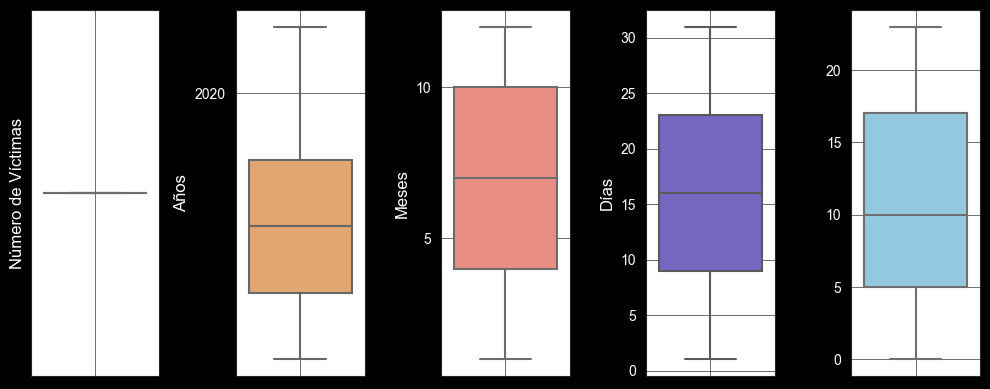

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Ajustar tamaño de la figura y fondo negro
plt.figure(figsize=(10, 4), facecolor='black')

# Cambiar estilo de gráfico
sns.set_style('white')

# Crear subplots y personalizar
plt.subplot(1, 5, 1)
sns.boxplot(data=hechos_victimas, y='N_VICTIMAS', color = "#FA8072", linewidth=1.5)
plt.ylabel('Número de Víctimas', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

plt.subplot(1, 5, 2)
sns.boxplot(data=hechos_victimas, y='AAAA', color = "#F4A460", linewidth=1.5)
plt.ylabel('Años', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

plt.subplot(1, 5, 3)
sns.boxplot(data=hechos_victimas, y='MM', color = "#FA8072", linewidth=1.5)
plt.ylabel('Meses', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

plt.subplot(1, 5, 4)
sns.boxplot(data=hechos_victimas, y='DD', color = "#6A5ACD", linewidth=1.5)
plt.ylabel('Días', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

# Columna auxiliar para hora numérica sin NaN
hechos_victimas['HORA_num'] = pd.to_datetime(hechos_victimas['HORA'], errors='coerce').dt.hour

plt.subplot(1, 5, 5)
sns.boxplot(data=hechos_victimas.dropna(subset=['HORA_num']), y='HORA_num', color = "#87CEEB", linewidth=1.5)
plt.ylabel('Horas', fontsize=12, color='white')
plt.yticks(color='white', fontsize=10)
plt.grid(color='#333333', linestyle='-', linewidth=0.5)

# Cambiar color de las etiquetas de los ejes
plt.xlabel('', color='white')
plt.ylabel('', color='white')

# Cambiar color de la escala de números y personalizar ancho de ticks
for ax in plt.gcf().axes:
    ax.tick_params(labelcolor='white', labelsize=10, width=1)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))  # Ajustar según tus necesidades

# Ajustar espaciado entre subplots
plt.tight_layout()

# Mostrar el gráfico
plt.show()


Busqueda de los valores 'SD' 

In [25]:
def encontrar_valores(df, valor_a_encontrar):
    resultados = []
    
    for columna in df.columns:
        columnas_con_valores = []
        indices_con_valores = []

        for indice, valor in df[columna].items():
            if valor == valor_a_encontrar:
                columnas_con_valores.append(columna)
                indices_con_valores.append(indice)
        
        if columnas_con_valores:
            resultados.append({
                'Columna': columna,
                'Indices': indices_con_valores
            })
    
    return resultados
columnasSD=encontrar_valores(hechos_victimas, 'SD')
columnasSD

[{'Columna': 'HORA', 'Indices': [536]},
 {'Columna': 'HH', 'Indices': [536]},
 {'Columna': 'LUGAR_DEL_HECHO', 'Indices': [121]},
 {'Columna': 'ACUSADO',
  'Indices': [3,
   33,
   36,
   39,
   58,
   77,
   84,
   93,
   107,
   114,
   121,
   128,
   141,
   162,
   204,
   208,
   223,
   409,
   413,
   457,
   468,
   475,
   641]},
 {'Columna': 'ROL',
  'Indices': [36, 39, 63, 77, 89, 141, 167, 208, 221, 280, 390]},
 {'Columna': 'VICTIMA', 'Indices': [36, 77, 89, 93, 141, 167, 208, 221, 280]},
 {'Columna': 'SEXO', 'Indices': [36, 39, 108, 121, 138, 141]},
 {'Columna': 'EDAD',
  'Indices': [30,
   33,
   35,
   36,
   39,
   55,
   63,
   72,
   89,
   93,
   108,
   119,
   121,
   138,
   141,
   142,
   165,
   176,
   182,
   225,
   243,
   275,
   277,
   299,
   328,
   359,
   367,
   371,
   377,
   391,
   421,
   444,
   446,
   454,
   457,
   461,
   463,
   469,
   478,
   497,
   505,
   528,
   529,
   548,
   552,
   555,
   563,
   572,
   579,
   631,
   639,
 

Inicio el manejo del SD en la columna horas en numeros enteros y hora en fracion

In [28]:
columna=['HH']
hechos_victimas=columns_modifier('replace',hechos_victimas,columna,'SD',np.nan)


In [26]:
columna=['HORA']
hechos_victimas=columns_modifier('replace',hechos_victimas,columna,'SD',np.nan)
columnasSD2=encontrar_valores(hechos_victimas,'SD')
columnasSD2

[{'Columna': 'HH', 'Indices': [536]},
 {'Columna': 'LUGAR_DEL_HECHO', 'Indices': [121]},
 {'Columna': 'ACUSADO',
  'Indices': [3,
   33,
   36,
   39,
   58,
   77,
   84,
   93,
   107,
   114,
   121,
   128,
   141,
   162,
   204,
   208,
   223,
   409,
   413,
   457,
   468,
   475,
   641]},
 {'Columna': 'ROL',
  'Indices': [36, 39, 63, 77, 89, 141, 167, 208, 221, 280, 390]},
 {'Columna': 'VICTIMA', 'Indices': [36, 77, 89, 93, 141, 167, 208, 221, 280]},
 {'Columna': 'SEXO', 'Indices': [36, 39, 108, 121, 138, 141]},
 {'Columna': 'EDAD',
  'Indices': [30,
   33,
   35,
   36,
   39,
   55,
   63,
   72,
   89,
   93,
   108,
   119,
   121,
   138,
   141,
   142,
   165,
   176,
   182,
   225,
   243,
   275,
   277,
   299,
   328,
   359,
   367,
   371,
   377,
   391,
   421,
   444,
   446,
   454,
   457,
   461,
   463,
   469,
   478,
   497,
   505,
   528,
   529,
   548,
   552,
   555,
   563,
   572,
   579,
   631,
   639,
   647,
   698]},
 {'Columna': 'FECHA_FAL

Para las columnas HORA Y HH los valores NaN los podemos remplazar la media por que la cantidad de datos faltantes es uno

In [29]:
def convertir_hora(decimal_hora):
    # Extraer la parte entera y decimal de la hora
    horas_enteras = int(decimal_hora)
    minutos_decimales = (decimal_hora - horas_enteras) * 60

    # Formatear como cadena de tiempo (HH:MM)
    hora_formateada = f"{horas_enteras:02d}:{int(minutos_decimales):02d}"

    return hora_formateada

hechos_victimas['HORA']=hechos_victimas['HORA'].fillna(convertir_hora(hechos_victimas['HH'].mean()))
hechos_victimas['HH']=hechos_victimas['HH'].fillna(hechos_victimas['HH'].mean()).apply(int)

Valido el indice 536 que las horas [HH] sean 11 y [horas] devuelva el promedio 

In [30]:
hechos_victimas.iloc[[536]]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Longitud,Latitud,PARTICIPANTES,ACUSADO,ROL,VICTIMA,SEXO,EDAD,FECHA_FALLECIMIENTO,HORA_num
536,2019-0103,1,2019-12-18,2019,12,18,11:33,11,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,...,-58.52169422,-34.59471640,MOTO-MOTO,MOTO,CONDUCTOR,MOTO,MASCULINO,24,2019-12-18 00:00:00,NaN


In [31]:
hechos_victimas.duplicated().sum()

0

buscamos el otro indice que contenia valores SD

In [32]:
hechos_victimas=columns_modifier('replace',hechos_victimas,['EDAD'],'SD',np.nan)
hechos_victimas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 717 entries, 0 to 716
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     717 non-null    object        
 1   N_VICTIMAS             717 non-null    int64         
 2   FECHA                  717 non-null    datetime64[ns]
 3   AAAA                   717 non-null    int64         
 4   MM                     717 non-null    int64         
 5   DD                     717 non-null    int64         
 6   HORA                   717 non-null    object        
 7   HH                     717 non-null    int64         
 8   LUGAR_DEL_HECHO        717 non-null    object        
 9   TIPO_DE_CALLE          717 non-null    object        
 10  Calle                  716 non-null    object        
 11  Altura                 133 non-null    float64       
 12  Cruce                  540 non-null    object        
 13  Direc

Filtro para validar el numero de accidentes por cada coordenada correspondiente a cada comuna

In [34]:
import pandas as pd
Accidentes_cordenada = hechos_victimas.groupby(['COMUNA', 'Puntero', 'AAAA'])['ID'].count()
Accidentes_cordenada = Accidentes_cordenada.reset_index()
tbla_resumen = Accidentes_cordenada.pivot(index=['COMUNA', 'Puntero'], columns='AAAA', values='ID')
tbla_resumen['Grand Total'] = tbla_resumen.sum(axis=1)
tbla_resumen = tbla_resumen.fillna('')
print(tbla_resumen)

AAAA                                           2016 2017 2018 2019 2020 2021   
COMUNA Puntero                                                                 
0      Point (. .)                              2.0                           \
1      Point (106608.39392805 100635.27735528)                 1.0             
       Point (106616.41069662 100496.44662323)  1.0                            
       Point (106672.04348602 102224.86809233)                      1.0        
       Point (106684.29090040 99706.57687843)   1.0                            
...                                             ...  ...  ...  ...  ...  ...   
15     Point (99305.05235104 105657.19134383)             1.0                  
       Point (99355.48397222 103660.98712619)        1.0                       
       Point (99641.71055660 105570.42188351)             1.0                  
       Point (99649.53744486 105547.74929043)                  1.0             
       Point (99810.88349598 103818.8786

Construccion de Indicador de la tendencia del número de Victimas por año

In [41]:
# Agrupar por año y mes, y sumar el número de víctimas
rel_tiempo = hechos_victimas.groupby(['AAAA', 'MM'])['N_VICTIMAS'].sum().reset_index()
rel_tiempo["AAAA"]= rel_tiempo["AAAA"].astype("Int64") # Se transforman los datos a tipo int
rel_tiempo["MM"]= rel_tiempo["MM"].astype("Int64")
rel_tiempo


,AAAA,MM,N_VICTIMAS
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [43]:
import plotly.graph_objects as go

# Combinar AÑO y MES para obtener una sola variable de tiempo
rel_tiempo["Fecha"] = rel_tiempo["AAAA"].astype(str) + '-' + rel_tiempo["MM"].astype(str)

# Convertir la variable de tiempo a formato datetime
rel_tiempo["Fecha"] = pd.to_datetime(rel_tiempo["Fecha"])

# Ordenar el DataFrame por fecha para que tenga orden cronológico
rel_tiempo = rel_tiempo.sort_values("Fecha")

# Crear trazas para el gráfico
trace1 = go.Scatter(
    x=rel_tiempo["Fecha"],
    y=rel_tiempo["N_VICTIMAS"],
    mode='lines+markers',
    name='Número de Víctimas',
    marker=dict(
        color='steelblue',
        size=8,
        opacity=0.8
    ),
    line=dict(
        color='steelblue',
        width=2
    )
)

# Ajustar el layout del gráfico
layout = go.Layout(
    title='Relación Temporal del Número de Víctimas (mes de enero de cada año)',
    xaxis=dict(
        title='Fecha',
        type='date',
        tickformat='%Y-%m'
    ),
    yaxis=dict(
        title='Número de Víctimas'
    ),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(
        color='white'
    )
)

# Crear la figura y agregar las trazas
fig = go.Figure(data=trace1, layout=layout)

# Mostrar el gráfico
fig.show()


In [44]:
import plotly.graph_objects as go
import pandas as pd

# Agrupar por cantidad de víctimas por mes
data = hechos_victimas.groupby(['MM'])['N_VICTIMAS'].sum().reset_index()

# Convertir la variable "MM" a tipo entero
data["MM"] = data["MM"].astype("Int64")

# Check data types and handle issues if needed
if not pd.api.types.is_numeric_dtype(data["MM"]):
    try:
        data["MM"] = data["MM"].astype(int)   
    except ValueError:
        print("Error: 'MM' column contains non-numeric values.")

# Crear trazas para el gráfico
trace1 = go.Bar(
    x=data["MM"],
    y=data["N_VICTIMAS"],
    name='Cantidad de Víctimas',
    marker=dict(
        color='orange',   
        line=dict(
            color='black',
            width=1
        )
    )
)

# Inicializar 'trace1.text' como una cadena vacía
trace1.text = ''

# Agregar etiquetas de número de víctimas en cada barra
for i in range(len(data)):
    trace1.text += f'{int(data["N_VICTIMAS"][i])}\n'   

# Ajustar el layout del gráfico
layout = go.Layout(
    title='Cantidad de Víctimas por Mes',
    xaxis=dict(
        title='Mes',
        type='category'
    ),
    yaxis=dict(
        title='Cantidad de Víctimas'
    ),
    plot_bgcolor='black',
    paper_bgcolor='black',
    font=dict(
        color='white'
    ),
    barmode='group'
)

# Crear la figura y agregar las trazas
fig = go.Figure(data=trace1, layout=layout)

# Mostrar el gráfico
fig.update_traces(textposition='outside', textfont=dict(size=20))
fig.show()


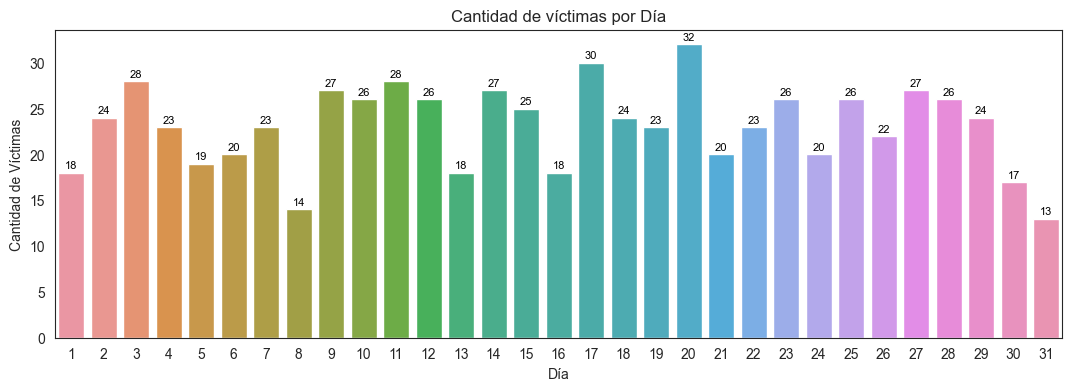

In [45]:
# Se agrupa por la cantidad de víctimas por dia
data = hechos_victimas.groupby(['DD'])['N_VICTIMAS'].sum().reset_index()
data["DD"]=data["DD"].astype("Int64")

# Se grafica
plt.figure(figsize=(13,4))

ax = sns.barplot(x='DD', y='N_VICTIMAS', data=data)
ax.set_title('Cantidad de víctimas por Día')
ax.set_xlabel('Día') ; ax.set_ylabel('Cantidad de Víctimas')
fig.update_layout(plot_bgcolor='black')
# Agregar etiquetas de número de víctimas en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                textcoords='offset points')

# Se muestra el gráfico
plt.show()


In [46]:
import plotly.graph_objects as go

victimas_por_fecha = hechos_victimas.groupby('AAAA')['ID'].count().reset_index()
victimas_por_fecha['Porcentaje'] = victimas_por_fecha['ID'] / victimas_por_fecha['ID'].sum()
textos = []
for porcentaje, cantidad in zip(victimas_por_fecha['Porcentaje'], victimas_por_fecha['ID']):
    textos.append('{:.1f}% - {}'.format(porcentaje, cantidad))
fig = go.Figure(data=[go.Bar(x=victimas_por_fecha['AAAA'], y=victimas_por_fecha['ID'],
                               text=textos)])
fig.update_layout(barmode='group',
                   xaxis_title='AÑOS',
                   yaxis_title='Número de Víctimas por año',
                   hovermode='closest',
                   )
# Mostrar la gráfica
fig.update_layout(plot_bgcolor='black')


fig.show()


In [47]:
import plotly.graph_objects as go

# Preparar los datos
victimas_por_comuna = hechos_victimas.groupby('COMUNA')['N_VICTIMAS'].sum().reset_index()

# Ordenar por comuna (opcional)
victimas_por_comuna = victimas_por_comuna.sort_values(by='COMUNA')

# Obtener valores de comuna y número de víctimas
x = victimas_por_comuna['COMUNA']
y = victimas_por_comuna['N_VICTIMAS']

# Crear la gráfica de barras
fig = go.Figure(data=[go.Bar(x=x, y=y)])

# Personalizar la gráfica
fig.update_layout(title='Número de Víctimas por Comuna',
                   xaxis_title='Comuna',
                   yaxis_title='Número de Víctimas',
                   xaxis=dict(tick0=None))

# Mostrar la gráfica
fig.show()


In [48]:
import plotly.graph_objects as go

# Preparar los datos
victimas_por_sexo = hechos_victimas.groupby('SEXO')['VICTIMA'].count().reset_index()
x = victimas_por_sexo['SEXO']
y = victimas_por_sexo['VICTIMA']

# Crear la gráfica de barras
fig = go.Figure(data=[go.Bar(x=x, y=y)])

# Personalizar la gráfica
fig.update_layout(title='Relación entre el Sexo de las Víctimas y el Número de Víctimas',
                   xaxis_title='Sexo',
                   yaxis_title='Número de Víctimas',
                   xaxis=dict(showgrid=True),
                   yaxis=dict(showgrid=True))

# Mostrar la gráfica
fig.show()


In [49]:
import plotly.graph_objects as go


hechos_victimas = hechos_victimas.dropna(subset=['EDAD'])
x = hechos_victimas['EDAD']
fig = go.Figure(data=[go.Histogram(x=x, marker_color='blue', marker_line_color='black')])
fig.update_layout(title='Distribución de Edades de las Víctimas',
                   xaxis_title='Edad',
                   yaxis_title='Frecuencia',
                   xaxis=dict(showgrid=True),
                   yaxis=dict(showgrid=True))


fig.show()


In [50]:
import plotly.graph_objects as go

# Define the color and the edge color of the histogram
color = 'blue'
edgecolor = 'black'

# Crea el trazo del histograma
hist_trace = go.Histogram(
    x=hechos_victimas['EDAD'],
    nbinsx=20,  
    marker_color=color,
    marker=dict(line=dict(color=edgecolor))  
)


layout = go.Layout(
    title='Distribución de Edades de las Víctimas',
    xaxis_title='Edad',
    yaxis_title='Frecuencia',
    yaxis=dict(showgrid=True), 
)

# Crea la figura y agrega el trazo
fig = go.Figure(data=[hist_trace], layout=layout)

# Muestra la figura
fig.show()


In [51]:
import plotly.graph_objects as go

data = hechos_victimas.groupby('MM')['ID'].count()
colors = ['blue']
fig = go.Figure()
fig.add_trace(go.Bar(
    x=data.index,
    y=data.values,
    marker_color=colors,
    text=data.values,
    textposition="outside"  
))


title = "Cantidad de Siniestros por Mes"
xaxis_title = "Mes"
yaxis_title = "Cantidad de Siniestros"
xaxis_tickvals = data.index
xaxis_ticktext = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
                 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
xaxis_tickangle = 0
yaxis_grid = True


fig.update_layout(
    title=title,
    xaxis_title=xaxis_title,
    yaxis_title=yaxis_title,
    xaxis_tickvals=xaxis_tickvals,
    xaxis_ticktext=xaxis_ticktext,
    xaxis_tickangle=xaxis_tickangle,
    yaxis=dict(showgrid=yaxis_grid) 
)


fig.show()


# Lesiones

In [52]:
hechos_lesiones=pd.read_excel('lesiones.xlsx',sheet_name='HECHOS')
victimas_lesiones=pd.read_excel('lesiones.xlsx',sheet_name='VICTIMAS')
hechos_lesiones['id'].sample(10)

21831    LC-2021-0496914
8701     LC-2019-0660887
2931     LC-2019-0259629
13640    LC-2020-0473681
21090    LC-2021-0432010
451      LC-2019-0040980
787      LC-2019-0070500
858      LC-2019-0351747
12272    LC-2020-0152837
13339    LC-2020-0431626
Name: id, dtype: object

In [90]:
victimas_lesiones.sample()

,ID hecho,AAA,MM,DD,FECHA,VEHICULO_VICTIMA,SEXO,EDAD_VICTIMA,GRAVEDAD
7870,LC-2019-0496495,2019,8,10,2019-08-10,sd,Varon,33,SD


In [53]:
hechos.describe()

,N_VICTIMAS,FECHA,AAAA,MM,DD,Altura,COMUNA
count,696.000000,696,696.000000,696.000000,696.000000,129.000000,696.000000
mean,1.030172,2018-09-14 05:12:24.827586048,2018.188218,6.692529,15.936782,3336.635659,7.425287
min,1.000000,2016-01-01 00:00:00,2016.000000,1.000000,1.000000,30.000000,0.000000
25%,1.000000,2017-04-02 12:00:00,2017.000000,4.000000,9.000000,1359.000000,4.000000
50%,1.000000,2018-07-12 12:00:00,2018.000000,7.000000,16.000000,2551.000000,8.000000
75%,1.000000,2020-01-04 06:00:00,2020.000000,10.000000,23.000000,4500.000000,11.000000
max,3.000000,2021-12-30 00:00:00,2021.000000,12.000000,31.000000,16080.000000,15.000000
std,0.179393,NaN,1.683754,3.571309,8.639646,3060.641793,4.387050


In [54]:
victimas_lesiones = victimas_lesiones.rename(columns={"ID hecho": "id"})
victimas_lesiones.sample()


,id,AAA,MM,DD,FECHA,VEHICULO_VICTIMA,SEXO,EDAD_VICTIMA,GRAVEDAD
15446,LC-2020-0625337,2020,11,22,2020-11-22,MOTO,Mujer,33,sd


In [93]:
# Combina los dataframes por la columna "id"
leciones_victimas = pd.merge(hechos_lesiones, victimas_lesiones, how="inner", on="id")